# Downloads metrics from wandb and plots selected results

In [70]:
import pandas as pd 
import wandb
import numpy as np
import sys
sys.path.append("../lib")
from data import dataloaders
from progressbar import progressbar as pbar
from rlxutils import subplots
import matplotlib.pyplot as plt

def query_wandb():
    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs("mindlab/qm4lp-test-experiments")

    summary_list, config_list, name_list, id_list, tags_list = [], [], [], [], []
    for run in runs: 
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
              if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)
        tags_list.append(run.tags)
        id_list.append(run.id)
    runs_df = pd.DataFrame({
        "id": id_list,
        "summary": summary_list,
        "config": config_list,
        "name": name_list,
        "tags": tags_list
        })

    runs_df.to_csv("project.csv")
    return runs_df

def conv_layer_summary(layer):
    ckeys = ['filters', 'kernel_size', 'strides']
    return "".join([f"{k[0]}{layer[k]}" for k in ckeys])

def get_config_keys(config):
    keys = ['loss', 'epochs', 'model_class', 'class_weights', 'trainable_params', 'learning_rate',
            'mae::test', 'f1::test', 'iou::test', 'mae::val', 'mae::train', 'fit_seconds.mean', 'inference_seconds.mean']
    r = { k: config[k] if k in config.keys() else None for k in keys }
    if 'dataloader_split_args' in config.keys():
        r['batch_size'] = config['dataloader_split_args']['batch_size']
        
    if 'model_init_args' in config.keys():
        for k,v in config['model_init_args'].items():
            if k  == 'conv_layers':
                ckeys = ['filters', 'kernel_size', 'strides']
                r[k] = " ".join([conv_layer_summary(layer) for layer in v])
            elif k == 'dense_layers':
                r[k] = len(v)                
            else:
                r[k] = v
        
    return r

def get_summary_keys(summary):
    keys = ['val/loss', 'train/loss', 'val/min_loss']
    r = { k: summary[k] if k in summary.keys() else None for k in keys }
    return r

def run_summary(run):
    d = dict(id = run['id'],
             name = run['name'])
    d.update(get_config_keys(run.config))
    d.update(get_summary_keys(run.summary))
    if 'wandb_tags' in run.config.keys():
        d.update({tag: True for tag in run.config['wandb_tags']})
    d.update({tag: True for tag in run.tags})
    d['tags'] = run.tags
    if 'metrics_args' in run.config.keys():
        d.update(run.config['metrics_args'])
    return d

def get_summary(runsets, loss, name_str=""):
    def list_has_substring(alist, substring):
        return np.alltrue(sum([substring in i for i in alist])>0)
    cols = ['id', 'model_class', 'trainable_params', 'learning_rate',
            'batch_size', 'loss', 'fit_seconds.mean', 'inference_seconds.mean',
            'train/loss', 'val/loss', 'mae::val', 'mae::test', 'f1::test', 'iou::test', 'tags']
    
    runsets = [runset for runset in runsets if runset.name.str.startswith(name_str).values.sum()>0]
    
    if len(runsets)>0:
        summary = []
        for runset in runsets:
            filtered_runset = runset[(runset.loss==loss)&(runset.name.str.startswith(name_str))]
            if len(filtered_runset)>0:
                summary.append(filtered_runset.sort_values(by='mae::val', ascending=True).iloc[0])

        summary = pd.DataFrame(summary)
        summary['loss_ratio'] = summary['val/loss'] / summary['train/loss']
        
        # add architecture to class name
        for tagstr in ['vgg', 'resnet']:
            summary['model_class']  = [r.model_class + f"_{tagstr}" if list_has_substring(r.tags, tagstr) else r.model_class  for i,r in summary.iterrows()]        
            
        summary = summary.set_index('model_class')
        summary.index = [i.replace("Segmentation", "") for i in summary.index]

        for col in summary.columns:
            if summary[col].dtype=='float64' and col!='learning_rate':
                summary[col] = summary[col].round(3)        
        
    else: 
        summary = None
    return summary

def plot_mae_vs_pxce(runsets_mse, runsets_pxce, metric='mae::test', title="", ax=None):
    p = pd.DataFrame([runsets_mse[metric], runsets_pxce[metric]], index=['mse', 'pxce']).T
    small_models = [i for i in p.index if 'downsampl' in i.lower() or 'qm' in i.lower()]
    other_models = [i for i in p.index if not i in small_models]
    models = small_models + other_models
    p = p.loc[models]
    p.plot(kind='bar', ax=ax)
    plt.title(metric+title)
    plt.grid();
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def plot_mae_vs_pxce_timings(runsets_mse, runsets_pxce, metric='mae::test', title="", show_legend = False, show_pxcebest_only=False,
                            xlim = None):
    
    nmap = {
        'SM_Unet_vgg': 'vgg16unet',
        'Custom_Unet': 'customunet',
        'QMPatch': 'qkm',
        'Custom_Downsampling': 'downconvs',
        'SM_Unet_resnet': 'resnet'
    }    
    
    nn = lambda t: nmap[t] if t in nmap.keys() else t
    
    y = runsets_mse['fit_seconds.mean'].copy()
    y[y==26.653] = 14.3
    
    plt.scatter(runsets_mse[metric], runsets_mse['fit_seconds.mean'], color="steelblue", label="mse")
    for _,i in runsets_mse.iterrows():
        y = i['fit_seconds.mean']
        if y==26.653:
            y=14.3
            
        # plt.text(i[metric]*1.01, y+(np.random.random()-.5)*2, nn(i.name))
        plt.text(i[metric], y+(np.random.random()-.5)*2, nn(i.name))
        
    if runsets_pxce is not None:
        if show_pxcebest_only:
            rr = runsets_pxce
            score = rr[metric].min() if metric=='mae::test' else rr[metric].max()
            plt.axvline(score, color="red", lw=2, label="score when using fine grained labels")
        else:
            plt.scatter(runsets_pxce[metric], runsets_pxce['fit_seconds.mean'], color="orange", label="pxce")
            for _,i in runsets_pxce.iterrows():
                plt.text(i[metric]*1.01, i['fit_seconds.mean']+(np.random.random()-.5)*4, nn(i.name))

                
    if xlim is not None:
        plt.xlim(*xlim)
    plt.grid()
    plt.xlabel(metric)
    plt.ylabel("training seconds per epoch")
    plt.title(metric+title)
    if show_legend:
        plt.legend()

In [71]:


def get_reference_scores(basedir, where, what, plot=False):

    dataloader_split_method, dataloader_split_args = dataloaders.get_dataloader(basedir, where, what,
                                                                            batch_size=8, 
                                                                            partitions_id='communes', 
                                                                            class_groups = None, 
                                                                            split_method = 'split')
    tr,ts,val = dataloader_split_method(**dataloader_split_args)

    z = []
    for x,(p,l) in pbar(tr):
        z.append(p)
    z_communes = np.r_[z].reshape(-1,p.shape[-1])
    p_mean_communes = z_communes.sum(axis=0)/z_communes.sum()
    
    
    dataloader_split_method, dataloader_split_args = dataloaders.get_dataloader(basedir, where, what,
                                                                                batch_size=8, 
                                                                                partitions_id='aschip', 
                                                                                class_groups = None, 
                                                                                split_method = 'split')
    tr,ts,val = dataloader_split_method(**dataloader_split_args)
    z = []
    for x,(p,l) in pbar(tr):
        z.append(p)
    z_chips = np.r_[z].reshape(-1,p.shape[-1])
    p_mean_chips = z_chips.sum(axis=0)/z_chips.sum()
    

    mae_pmean_communes = np.sqrt((z_chips - p_mean_communes)**2).mean(axis=1)
    mae_pmean_chips    = np.sqrt((z_chips - p_mean_chips)**2).mean(axis=1)
    
    if plot:
        plt.hist(mae_pmean_communes, bins=30, density=True, alpha=.5, label=f"prediction is communes mean, mean MAE = {mae_pmean_communes.mean():.4f} ", color="steelblue")
        plt.hist(mae_pmean_chips, bins=30, density=True, alpha=.5, label=f"prediction is chips mean, mean MAE = {mae_pmean_chips.mean():.4f}", color="orange")
        plt.axvline(mae_pmean_communes.mean(), color="steelblue")
        plt.axvline(mae_pmean_chips.mean(), color="orange")
        plt.legend()
        plt.grid();
        plt.xlabel("MAE")
        plt.title(f"MAE with regression to mean prediction\n{what}  {where}")
    return {'pmean_communes': p_mean_communes, 
            'pmean_chips': p_mean_chips, 
            'mae_communes': mae_pmean_communes, 
            'mae_chips': mae_pmean_chips}

def plot_results(dataset, where, yvar='fit_seconds.mean', metric='mae::test', ref_value=None, label_ref='mean proportions as prediction', 
                 show_legend=False, show_pxcebest_only=False, xlim=None):    
    
    runs = pd.DataFrame([run_summary(r) for _,r in runs_df.iterrows()])
    runs = runs[[dataset in i.tags for _,i in runs.iterrows()]]
    runs = runs[~runs[yvar].isna()]

    cols = ['id', 'model_class', 'trainable_params', 'learning_rate',
            'batch_size', 'conv_layers', 'loss', 'fit_seconds.mean', 'inference_seconds.mean',
            'train/loss', 'val/loss', 'mae::val', 'mae::test', 'f1::test', 'iou::test', 'tags', 'name']

    runsdowns = truns = runs[(~runs['set13'].isna()) & (runs.model_class.str.contains('Downsampling'))][cols].sort_values(by='mae::val', ascending=True)
    runsvgg = runs[(~runs['set13'].isna()) & (runs.model_class.str.contains('SM_UnetSegmentation')) &\
                   ([sum(['vgg' in i for i in tags])>0 for tags in runs.tags])][cols].sort_values(by='mae::val', ascending=True)

    runsresnet = runs[(~runs['set13'].isna()) & (runs.model_class.str.contains('SM_UnetSegmentation')) &\
                   ([sum(['resnet' in i for i in tags])>0 for tags in runs.tags])][cols].sort_values(by='mae::val', ascending=True)

    runcustomunet = runs[(~runs['set13'].isna()) & (runs.model_class.str.contains('Custom_Une'))][cols].sort_values(by='mae::val', ascending=True)

    cols = ['id', 'model_class', 'trainable_params', 'learning_rate', 'fit_seconds.mean', 'inference_seconds.mean',
            'batch_size', 'n_comp', 'deep', 'patch_size', 'pred_strides', 'mae_proportions_argmax',
            'loss', 'train/loss', 'val/loss', 'mae::val', 'mae::test', 'f1::test', 'iou::test', 'tags', 'name']
    runsqpatch = runs[(~runs['set13'].isna()) & (runs.model_class.str.contains('QMPatch'))][cols].sort_values(by='mae::val', ascending=True)

    cols_report =  [ 'trainable_params', 'learning_rate', 'loss_ratio','mae::val','mae::test','f1::test','iou::test', 'fit_seconds.mean', 'inference_seconds.mean', 'tags']

    runsets = [runsdowns, runsvgg, runcustomunet, runsqpatch] #, runsresnet]
    runsets_mse  = get_summary(runsets, 'mse', name_str=where)[cols_report]
    runsets_pxce = get_summary(runsets, 'pxce', name_str=where)[cols_report]

    nmap = {'colo': r'$\tt{colombia-ne}$', 'bene': r'$\tt{benelux}$' }
    if where in nmap.keys():
        where = nmap[where]
        
    year = '2020' if dataset == 'esaworldcover' else '2015'
    plot_mae_vs_pxce_timings(runsets_mse, runsets_pxce, metric, f'   {where}   {dataset}', show_pxcebest_only=show_pxcebest_only, xlim=xlim)
    
    if ref_value is not None:
        plt.axvline(ref_value, color="black", lw=2, label=label_ref)

    if show_legend:
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=1)
    return [runsets_mse, runsets_pxce]


# Reference scores

In [37]:
# these scores are calculated below, we keep them here to avoid re-running
ref_bene_esaworldcover = .1650
ref_colo_esaworldcover = .1258
ref_bene_humanpop = .1978
ref_colo_humanpop = .0244

In [4]:
basedir = '/opt/data/'

In [ ]:
r = get_reference_scores(basedir, where='benelux', what='esa-world-cover', plot=True)
ref_bene_esaworldcover = r['mae_communes'].mean()

In [ ]:
r = get_reference_scores(basedir, where='colombia-ne', what='esa-world-cover', plot=True)
ref_colo_esaworldcover = r['mae_communes'].mean()


In [ ]:
r = get_reference_scores(basedir, where='benelux', what='humanpop2015', plot=True)
ref_bene_humanpop = r['mae_communes'].mean()


In [ ]:
r = get_reference_scores(basedir, where='colombia-ne', what='humanpop2015', plot=True)
ref_colo_humanpop = r['mae_communes'].mean()


In [480]:
ref_bene_esaworldcover = r['mae_communes'].mean()

# Results plots

In [62]:
# load from wandb
runs_df = query_wandb()

In [63]:
runs_df.shape

(902, 5)

In [67]:
nmap = {
    'SM_Unet_vgg': 'vgg16unet',
    'Custom_Unet': 'customunet',
    'QMPatch': 'qkm',
    'Custom_Downsampling': 'downconvs',
    'SM_Unet_resnet': 'resnet'
}

## esa world cover

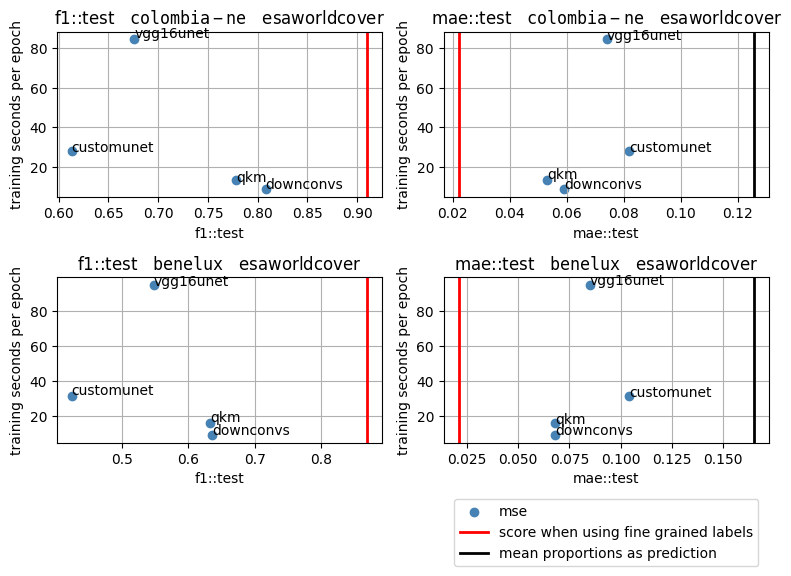

In [69]:
for ax,i in subplots(4,usizex=4, usizey=3, n_cols=2):
    if i==0: 
        plot_results('esaworldcover', 'colo', metric='f1::test', show_pxcebest_only=True);
    if i==1: 
        rcolo,_ = plot_results('esaworldcover', 'colo', metric='mae::test', ref_value=ref_colo_esaworldcover, show_pxcebest_only=True);    
    if i==2: 
        plot_results('esaworldcover', 'bene', metric='f1::test', show_pxcebest_only=True);
    if i==3: 
        rbene,_ = plot_results('esaworldcover', 'bene', metric='mae::test', ref_value=ref_bene_esaworldcover, show_legend=True, show_pxcebest_only=True);


In [175]:
rbene

,trainable_params,learning_rate,loss_ratio,mae::val,mae::test,f1::test,iou::test,fit_seconds.mean,inference_seconds.mean,tags
Custom_Downsampling,5189,0.0010,0.844,0.069,0.068,0.636,0.285,9.182,1.215,"[5 classes, classicconfs.downsampl09, esaworld..."
SM_Unet_vgg,23748821,0.0001,11.512,0.085,0.085,0.548,0.198,94.569,7.681,"[5 classes, classicconfs.smvgg16_mse, esaworld..."
Custom_Unet,482101,0.0001,1.529,0.101,0.104,0.425,0.141,31.310,4.988,"[5 classes, classicconfs.unet04, esaworldcover..."
QMPatch,3457,0.0001,0.859,0.069,0.068,0.633,0.276,15.899,3.504,"[5 classes, esaworldcover, kqmconfs.qmp06aa, s..."


In [177]:
rcolo

,trainable_params,learning_rate,loss_ratio,mae::val,mae::test,f1::test,iou::test,fit_seconds.mean,inference_seconds.mean,tags
Custom_Downsampling,5189,0.0001,0.978,0.082,0.059,0.808,0.463,8.661,1.476,"[5 classes, classicconfs.downsampl09, esaworld..."
SM_Unet_vgg,23748821,0.0001,2.836,0.078,0.074,0.676,0.176,84.353,8.759,"[5 classes, classicconfs.smvgg16_mse, esaworld..."
Custom_Unet,482101,0.0001,1.291,0.082,0.082,0.613,0.199,27.908,5.661,"[5 classes, classicconfs.unet04, esaworldcover..."
QMPatch,1153,0.0001,1.052,0.065,0.053,0.778,0.430,13.308,3.944,"[5 classes, esaworldcover, kqmconfs.qmp06b, se..."


In [ ]:
qmp06aa  qmp06b qmp03a

qmp06a = dict(model_class = kqm.QMPatchSegmentation,
             model_init_args = dict(patch_size=6, pred_strides=2, n_comp=64, sigma_ini=None,deep=False),
             loss = 'mse', learning_rate=0.0001)                            

qmp06aa = dict(model_class = kqm.QMPatchSegmentation,
                     model_init_args = dict(patch_size=4, pred_strides=2, n_comp=64, sigma_ini=None,deep=False),
                                  loss = 'mse', learning_rate=0.0001)

qmp03b = dict(model_class = kqm.QMPatchSegmentation,
             model_init_args = dict(patch_size=4, pred_strides=4, n_comp=64, sigma_ini=None,deep=False))                            


# humanpop

,trainable_params,learning_rate,loss_ratio,mae::val,mae::test,f1::test,iou::test,fit_seconds.mean,inference_seconds.mean,tags
Custom_Downsampling,6275,0.0010,0.976,0.022,0.015,0.978,0.920,23.326,3.029,"[3 classes, classicconfs.downsampl05, humanpop..."
SM_Unet_vgg,23748531,0.0001,1.168,0.028,0.021,0.967,0.323,175.211,33.220,"[3 classes, classicconfs.smvgg16_mse, humanpop..."
Custom_Unet,482067,0.0001,1.140,0.032,0.026,0.958,0.320,101.453,19.864,"[3 classes, classicconfs.unet04, humanpop, set13]"
QMPatch,20421,0.0010,1.061,0.022,0.015,0.978,0.919,65.676,25.746,"[3 classes, humanpop, kqmconfs.qmp03s1d, set13]"


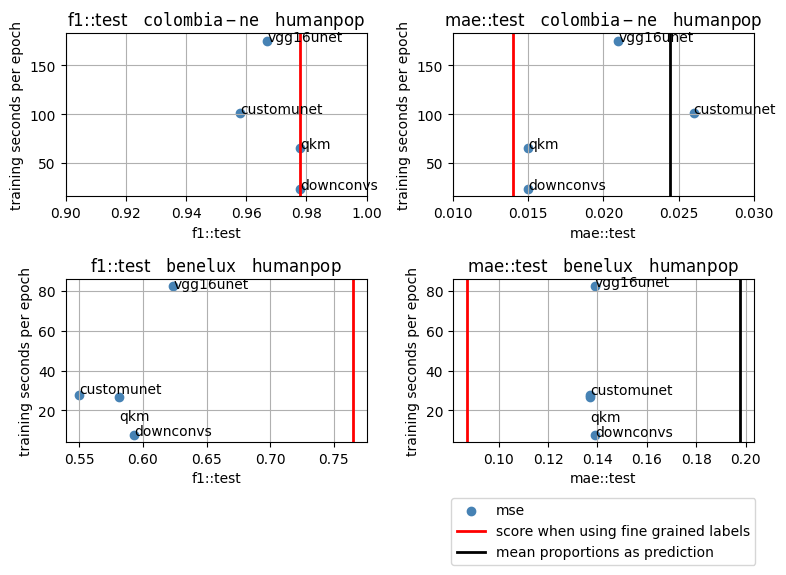

In [76]:
for ax,i in subplots(4,usizex=4, usizey=3, n_cols=2):
    if i==0: plot_results('humanpop', 'colo', metric='f1::test', show_pxcebest_only=True, xlim=(0.9, 1.0));
    if i==1: 
        hcol, _ = plot_results('humanpop', 'colo', metric='mae::test', ref_value = ref_colo_humanpop, show_pxcebest_only=True, xlim=(0.01, 0.03));
    if i==2: plot_results('humanpop', 'bene', metric='f1::test', show_pxcebest_only=True);
    if i==3:
        hbene,_ = plot_results('humanpop', 'bene', metric='mae::test', ref_value = ref_bene_humanpop, show_legend=True, show_pxcebest_only=True);
hcol